# Radiative Equilibrium

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

____________
<a id='section1'></a>

## 1. The observed annual, global mean temperature profile
____________

Let's look again the observations of air temperature from the NCEP Reanalysis data we first encountered in the [Radiation notes](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/radiation.html).

In this notebook  we'll define a function to create the Skew-T diagram, because later we are going to reuse it several times.

*Click to expand code cells to see Python details* 

In [1]:
#  This code is used just to create the skew-T plot of global, annual mean air temperature
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from metpy.plots import SkewT
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc", use_cftime=True)
#  Take global, annual average 
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [2]:
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

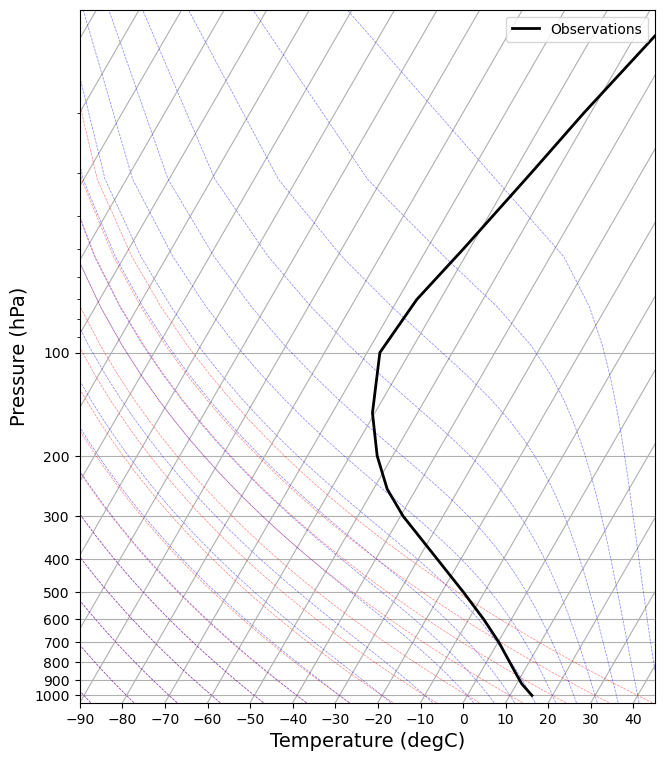

In [3]:
skew = make_skewT()

Here we are going to work with some detailed **Single-Column Models** to understand questions such as

- What physical factors actually determine this profile? 
- Would the profile be different with different gases in the atmosphere?
- What are the relative roles of **radiation** and **dynamics** (i.e. motion!) in setting this profile?

We will start by **ignoring all processes except radiation**. We will calculate something called the **radiative equilibrium** temperature.

____________

## 2. Radiative equilibrium -- the concept
____________

Models of radiative transfer slice up the atmospheric air column into a series of layer, and calculate the **emission** and **absorption** of radiation within each layer.

It's really just a generalization of the model we already looked at:

![Sketch of layer model](http://www.atmos.albany.edu/facstaff/brose/classes/ENV415_Spring2018/images/2layerAtm_sketch.png)

The concept of **radiative equilibrium** means that we **ignore all methods of heat exchange except for radiation**, and ask what temperature profile would exist under that assumption?

We can answer that question by using a radiative transfer model to explicity compute the shortwave and longwave beams, and the warming/cooling of each layer associated with the radiative sources and sinks of energy.

Basically, we reach radiative equilibrium when **energy is received and lost through radiation at the same rate in every layer**.

Because of the complicated dependence of emission/absorption features on the wavelength of radiation and the different gases, the beam is divided up into many different pieces representing different parts of the electromagnetic spectrum.

We will not look explicitly at this complexity here, but we will **use a model** that represents these processes at the same level of detail we would in a GCM.

____________

## 3. Setting up a single-column radiation model in climlab
____________

### Radiation models in climlab

We're now going to use **climlab** to run a **complex radiation model**, one that accounts for the spectral absorption properties of different gases.

climlab actually provides two different "GCM-level" [radiation codes](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.Radiation.html):

- The [CAM3 radiation module](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.CAM3.html) from NCAR (essentially the same radiation code used in our CESM simulations)
- The [RRTMG (Rapid Radiative Transfer Model)](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.RRTMG.html) which is used in many current GCMs.

The links above take you to the online [climlab documentation](http://climlab.readthedocs.io/en/latest/intro.html).

We're going to use a model called the [Rapid Radiative Transfer Model](http://rtweb.aer.com/rrtm_frame.html) or RRTMG. This is a "serious" and widely-used radiation model, used in many comprehensive GCMs and Numerical Weather Prediction models.

climlab provides an easy-to-use Python wrapper for the RRTMG code.

### Water vapor data

Before setting up the model, we need some water vapor data. Why? Because our model needs to know how much water vapor exists at each vertical level, since water vapor is a radiatively important gas.

We're actually going to use the specific humidity field from our CESM control simulation. We'll just take the global, time average of this data, and plot its vertical profile.

In [4]:
#  Load the model output as we have done before
cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")
#  The specific humidity is stored in the variable called Q in this dataset:
atm_control.Q

<xarray.DataArray 'Q' (time: 240, lev: 26, lat: 96, lon: 144)>
[86261760 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

Now take the global, annual average of the specific humidity:

In [6]:
# Take global, annual average of the specific humidity
weight_factor = atm_control.gw / atm_control.gw.mean(dim='lat')
Qglobal = (atm_control.Q * weight_factor).mean(dim=('lat','lon','time'))
# Take a look at what we just calculated ... it should be one-dimensional (vertical levels)
Qglobal

<xarray.DataArray (lev: 26)>
array([2.16104904e-06, 2.15879387e-06, 2.15121262e-06, 2.13630949e-06,
       2.12163684e-06, 2.11168002e-06, 2.09396914e-06, 2.10589390e-06,
       2.42166155e-06, 3.12595653e-06, 5.01369691e-06, 9.60746488e-06,
       2.08907654e-05, 4.78823747e-05, 1.05492451e-04, 2.11889055e-04,
       3.94176751e-04, 7.10734458e-04, 1.34192099e-03, 2.05153261e-03,
       3.16844784e-03, 4.96883408e-03, 6.62218037e-03, 8.38350326e-03,
       9.38620899e-03, 9.65030544e-03])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6

And make a figure:

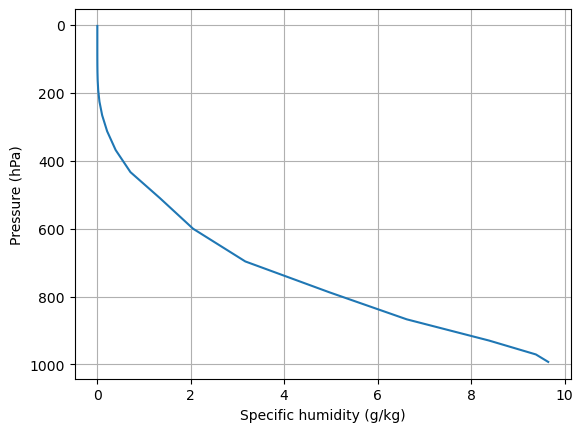

In [7]:
fig, ax = plt.subplots()
#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
ax.plot(Qglobal*1000., Qglobal.lev)
ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Specific humidity (g/kg)')
ax.grid()

This shows a typical climatological humidity profile. Water vapor is a **trace gas**! But as we will see, it plays a very important role.

Based on this figure, where is most of the water vapor?

### Create a single-column model on the same grid as this water vapor data:

Here we will create the grid and state variables (air and surface temperature) for our single-column model.

In [8]:
import climlab
#  Make a model on same vertical domain as the GCM
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
mystate

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

In [9]:
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                             )
radmodel

### Explore the single-column model object

Look at a few interesting properties of the model we just created:

In [10]:
#  Here's the state dictionary we already created:
radmodel.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

In [11]:
#  Here are the pressure levels in hPa
radmodel.lev

array([  3.544638 ,   7.3888135,  13.967214 ,  23.944625 ,  37.23029  ,
        53.114605 ,  70.05915  ,  85.439115 , 100.514695 , 118.250335 ,
       139.115395 , 163.66207  , 192.539935 , 226.513265 , 266.481155 ,
       313.501265 , 368.81798  , 433.895225 , 510.455255 , 600.5242   ,
       696.79629  , 787.70206  , 867.16076  , 929.648875 , 970.55483  ,
       992.5561   ])

There is a dictionary called `absorber_vmr` that holds the *volume mixing ratio* of all the radiatively active gases in the column:

In [12]:
radmodel.absorber_vmr

{'CO2': 0.000348,
 'CH4': 1.65e-06,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CCL4': 0.0,
 'O3': array([7.52507018e-06, 8.51545793e-06, 7.87041289e-06, 5.59601020e-06,
        3.46128454e-06, 2.02820936e-06, 1.13263102e-06, 7.30182697e-07,
        5.27326553e-07, 3.83940962e-07, 2.82227214e-07, 2.12188506e-07,
        1.62569291e-07, 1.17991442e-07, 8.23582543e-08, 6.25738219e-08,
        5.34457156e-08, 4.72688637e-08, 4.23614749e-08, 3.91392482e-08,
        3.56025264e-08, 3.12026770e-08, 2.73165152e-08, 2.47190016e-08,
        2.30518624e-08, 2.22005071e-08])}

Most are just a single number because they are assumed to be **well mixed** in the atmosphere.

The exception is ozone, which has a vertical structure taken from observations. Let's plot it

In [13]:
#  E.g. the CO2 content (a well-mixed gas) in parts per million
radmodel.absorber_vmr['CO2'] * 1E6

348.0

### Python exercise: plot the ozone profile

Make a simple plot showing the vertical structure of ozone, similar to the specific humidity plot we just made above.

In [14]:
# here is the data you need for the plot, as a plain numpy arrays:
print(radmodel.lev)
print(radmodel.absorber_vmr['O3'])

[  3.544638    7.3888135  13.967214   23.944625   37.23029    53.114605
  70.05915    85.439115  100.514695  118.250335  139.115395  163.66207
 192.539935  226.513265  266.481155  313.501265  368.81798   433.895225
 510.455255  600.5242    696.79629   787.70206   867.16076   929.648875
 970.55483   992.5561   ]
[7.52507018e-06 8.51545793e-06 7.87041289e-06 5.59601020e-06
 3.46128454e-06 2.02820936e-06 1.13263102e-06 7.30182697e-07
 5.27326553e-07 3.83940962e-07 2.82227214e-07 2.12188506e-07
 1.62569291e-07 1.17991442e-07 8.23582543e-08 6.25738219e-08
 5.34457156e-08 4.72688637e-08 4.23614749e-08 3.91392482e-08
 3.56025264e-08 3.12026770e-08 2.73165152e-08 2.47190016e-08
 2.30518624e-08 2.22005071e-08]


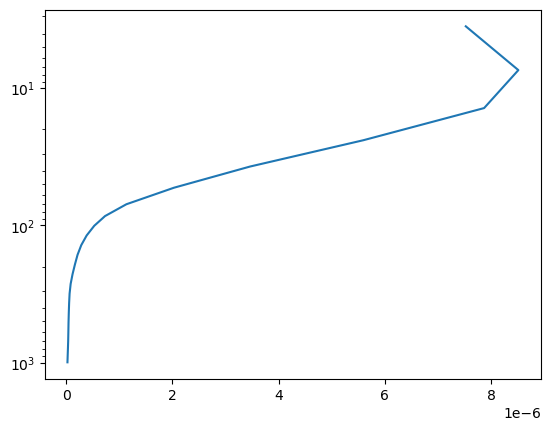

In [19]:
plt.plot(radmodel.absorber_vmr['O3'], radmodel.lev)
plt.yscale('log')
plt.gca().invert_yaxis()
plt.show()

The other radiatively important gas is of course water vapor, which is stored separately in the `specific_humidity` attribute:

In [20]:
#  specific humidity in kg/kg, on the same pressure axis
radmodel.specific_humidity

array([2.16104904e-06, 2.15879387e-06, 2.15121262e-06, 2.13630949e-06,
       2.12163684e-06, 2.11168002e-06, 2.09396914e-06, 2.10589390e-06,
       2.42166155e-06, 3.12595653e-06, 5.01369691e-06, 9.60746488e-06,
       2.08907654e-05, 4.78823747e-05, 1.05492451e-04, 2.11889055e-04,
       3.94176751e-04, 7.10734458e-04, 1.34192099e-03, 2.05153261e-03,
       3.16844784e-03, 4.96883408e-03, 6.62218037e-03, 8.38350326e-03,
       9.38620899e-03, 9.65030544e-03])

### The RRTMG radiation model has lots of different input parameters

For details you can look at the [documentation](http://climlab.readthedocs.io/en/latest/api/climlab.radiation.Radiation.html)

In [21]:
for item in radmodel.input:
    print(item)

specific_humidity
absorber_vmr
cldfrac
clwp
ciwp
r_liq
r_ice
emissivity
S0
insolation
coszen
eccentricity_factor
aldif
aldir
asdif
asdir
icld
irng
idrv
permuteseed_sw
permuteseed_lw
dyofyr
inflgsw
inflglw
iceflgsw
iceflglw
liqflgsw
liqflglw
tauc_sw
tauc_lw
ssac_sw
asmc_sw
fsfc_sw
tauaer_sw
ssaaer_sw
asmaer_sw
ecaer_sw
tauaer_lw
isolvar
indsolvar
bndsolvar
solcycfrac


Many of the parameters control the **radiative effects of clouds**.

But here we should note that the model is **initialized with no clouds at all**:

In [22]:
#  This is the fractional area covered by clouds in our column:
radmodel.cldfrac

0.0

____________

## 4. Radiative equilibrium in the single-column model
____________

### Step the model forward in time!

Here are the current temperatures (initial condition):

In [23]:
radmodel.Ts

Field([288.])

In [24]:
radmodel.Tatm

Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])

Now let's take a single timestep:

In [25]:
radmodel.step_forward()

In [26]:
radmodel.Ts

Field([288.57727148])

The surface got warmer! 

Let's take a look at all the diagnostic information that was generated during that timestep:

### Diagnostic variables in our single-column model

Every climlab model has a `diagnostics` dictionary. Here we are going to check it out as an `xarray` dataset:

In [27]:
climlab.to_xarray(radmodel.diagnostics)

<xarray.Dataset>
Dimensions:           (depth: 1, lev: 26, lev_bounds: 27, depth_bounds: 2)
Coordinates:
  * depth             (depth) float64 1.25
  * lev               (lev) float64 3.545 7.389 13.97 ... 929.6 970.6 992.6
  * depth_bounds      (depth_bounds) float64 0.0 2.5
  * lev_bounds        (lev_bounds) float64 0.0 5.467 10.68 ... 950.1 981.6 1e+03
Data variables: (12/26)
    OLR               (depth) float64 251.0
    OLRclr            (depth) float64 251.0
    OLRcld            (depth) float64 0.0
    TdotLW            (lev) float64 -1.505 -0.8463 -0.8035 ... -0.1981 1.523
    TdotLW_clr        (lev) float64 -1.505 -0.8463 -0.8035 ... -0.1981 1.523
    LW_sfc            (depth) float64 93.93
    ...                ...
    SW_flux_up        (lev_bounds) float64 86.52 86.35 86.24 ... 54.9 54.59
    SW_flux_down      (lev_bounds) float64 341.3 335.3 333.1 ... 220.3 218.4
    SW_flux_net       (lev_bounds) float64 254.8 248.9 246.8 ... 165.4 163.8
    SW_flux_up_clr    (lev_bounds) float64 86.52 86.35 86.24 ... 54.9 54.59
    SW_flux_down_clr  (lev_bounds) float64 341.3 335.3 333.1 ... 220.3 218.4
    SW_flux_net_clr   (lev_bounds) float64 254.8 248.9 246.8 ... 165.4 163.8

The main "job" of a radiative transfer model it to calculate the shortwave and longwave fluxes up and down between each model layer.

For example:

In [28]:
climlab.to_xarray(radmodel.LW_flux_up)

<xarray.DataArray (lev_bounds: 27)>
array([251.01459806, 251.25313801, 251.62168892, 252.36094038,
       253.49760842, 254.94148495, 256.51042674, 257.95176838,
       259.23376945, 260.55457866, 261.96972717, 263.51365698,
       265.24255886, 267.2270195 , 269.61795334, 272.55968463,
       276.15994067, 280.45320896, 285.55601094, 291.88950856,
       299.3801653 , 308.24370169, 319.18061254, 331.81032106,
       346.00223519, 360.37156583, 390.0990181 ])
Coordinates:
  * lev_bounds  (lev_bounds) float64 0.0 5.467 10.68 18.96 ... 950.1 981.6 1e+03

These are upward longwave fluxes in W/m2.

Why are there 27 data points, when the model has 26 pressure levels?

In [29]:
radmodel.lev

array([  3.544638 ,   7.3888135,  13.967214 ,  23.944625 ,  37.23029  ,
        53.114605 ,  70.05915  ,  85.439115 , 100.514695 , 118.250335 ,
       139.115395 , 163.66207  , 192.539935 , 226.513265 , 266.481155 ,
       313.501265 , 368.81798  , 433.895225 , 510.455255 , 600.5242   ,
       696.79629  , 787.70206  , 867.16076  , 929.648875 , 970.55483  ,
       992.5561   ])

In [30]:
radmodel.lev_bounds

array([   0.        ,    5.46672575,   10.67801375,   18.9559195 ,
         30.5874575 ,   45.1724475 ,   61.5868775 ,   77.7491325 ,
         92.976905  ,  109.382515  ,  128.682865  ,  151.3887325 ,
        178.1010025 ,  209.5266    ,  246.49721   ,  289.99121   ,
        341.1596225 ,  401.3566025 ,  472.17524   ,  555.4897275 ,
        648.660245  ,  742.249175  ,  827.43141   ,  898.4048175 ,
        950.1018525 ,  981.555465  , 1000.        ])

The last element of the flux array represents the **upward flux from the surface to the first level**:

In [31]:
radmodel.LW_flux_up[-1]

390.0990181032836

The value is about 390 W m$^{-2}$. 

Why?

In [32]:
sigma = 5.67E-8
sigma * 288**4

390.0793946112

The surface temperature was initialized at 288 K, and the surface is treated as very close to a blackbody in the model.

What about the flux from the top layer out to space?

Two ways to access this information:

In [33]:
radmodel.LW_flux_up[0]

251.01459805907507

In [34]:
radmodel.OLR

Field([251.01459806])

Of course there is a whole other set of fluxes for the shortwave radiation.

One diagnostic we will often want to look at is the **net energy budget at the top of the atmosphere**:

In [35]:
radmodel.ASR - radmodel.OLR

Field([3.76767763])

***Is the model gaining or losing energy?***

### Integrate out to equilibrium

Here I want to step forward in time until the model is very close to energy balance.

We can use a `while` loop, conditional on the top-of-atmosphere imbalance:

In [36]:
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    radmodel.step_forward()

Check the energy budget again:

In [37]:
#  Check the energy budget again
radmodel.ASR - radmodel.OLR

Field([0.00988074])

Indeed, the imbalance is now small.

### Compare the radiative equilibrium temperature to observations

Here's a helper function we'll use to add model temperature profiles to our skew-T plot:

In [41]:
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

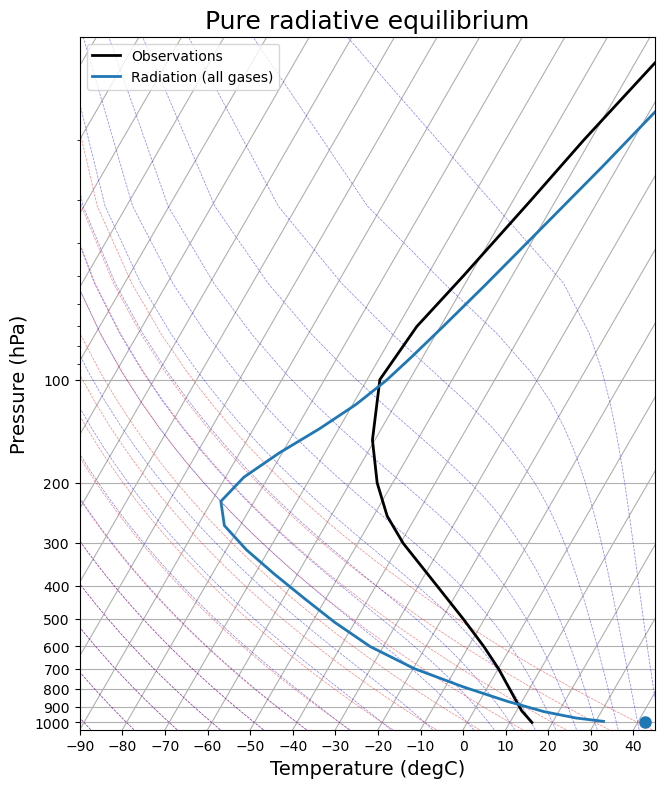

In [42]:
skew = make_skewT()
add_profile(skew, radmodel)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

What do you think about this model -- data comparison?

____________

## 5. Effects of different gases on the radiative equilibrium profile
____________

**Models are for experimenting and playing with!**

We have just built a single-column radiation model with several different absorbing gases. *We can learn about their effects by taking them away.*

### Radiative equilibrium without water vapor

In [43]:
# Make an exact clone of our existing model
radmodel_noH2O = climlab.process_like(radmodel)
radmodel_noH2O.name = 'Radiation (no H2O)'
radmodel_noH2O

In [44]:
#  Here is the water vapor profile we started with
radmodel_noH2O.specific_humidity

array([2.16104904e-06, 2.15879387e-06, 2.15121262e-06, 2.13630949e-06,
       2.12163684e-06, 2.11168002e-06, 2.09396914e-06, 2.10589390e-06,
       2.42166155e-06, 3.12595653e-06, 5.01369691e-06, 9.60746488e-06,
       2.08907654e-05, 4.78823747e-05, 1.05492451e-04, 2.11889055e-04,
       3.94176751e-04, 7.10734458e-04, 1.34192099e-03, 2.05153261e-03,
       3.16844784e-03, 4.96883408e-03, 6.62218037e-03, 8.38350326e-03,
       9.38620899e-03, 9.65030544e-03])

Now get rid of the water entirely!

In [45]:
radmodel_noH2O.specific_humidity *= 0.

In [46]:
radmodel_noH2O.specific_humidity

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

And run this new model forward to equilibrium:

In [47]:
#  it's useful to take a single step first before starting the while loop
#   because the diagnostics won't get updated 
#  (and thus show the effects of removing water vapor)
#  until we take a step forward
radmodel_noH2O.step_forward()
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR) > 0.01:
    radmodel_noH2O.step_forward()

In [48]:
radmodel_noH2O.ASR - radmodel_noH2O.OLR

Field([-0.00999903])

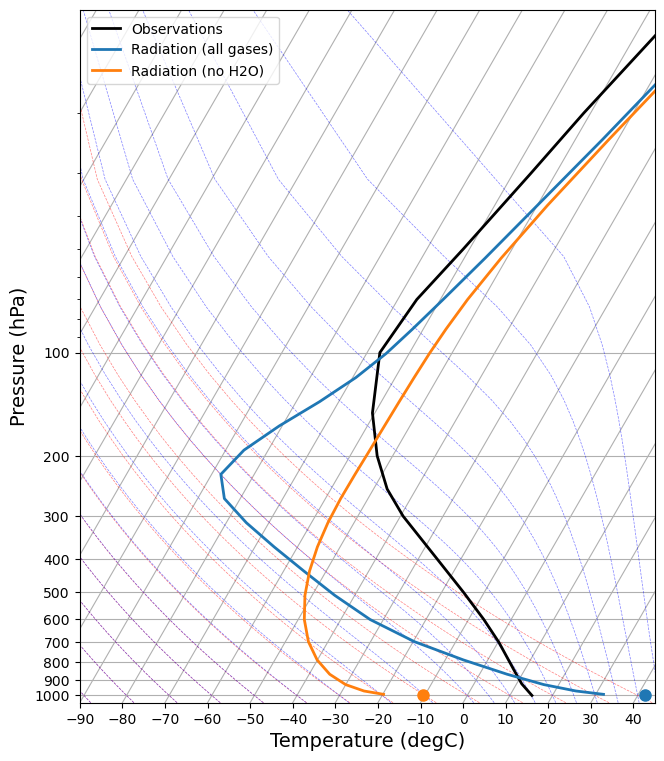

In [49]:
skew = make_skewT()
for model in [radmodel, radmodel_noH2O]:
    add_profile(skew, model)

What do you think you can learn from this about the radiative role of water vapor?

### Exercise: radiative equilibrium without ozone

Following the steps above, make another model, but this time instead of removing the water vapor, remove the ozone!

Make another skew-T plot comparing all three model results.

If you have time, try a third case in which you remove both the water vapor and the ozone!

In [50]:
radmodel_noO3 = climlab.process_like(radmodel)
radmodel_noO3.name = 'Radiation (no O3)'
radmodel_noO3

In [61]:
radmodel_noO3.absorber_vmr['O3'] *= 0
radmodel_noO3.absorber_vmr

{'CO2': 0.000348,
 'CH4': 1.65e-06,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CCL4': 0.0,
 'O3': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [62]:
radmodel_noO3.step_forward()
while np.abs(radmodel_noO3.ASR - radmodel_noO3.OLR) > 0.01:
    radmodel_noO3.step_forward()

In [63]:
print(radmodel_noO3.ASR - radmodel_noO3.OLR)

[-0.00999585]


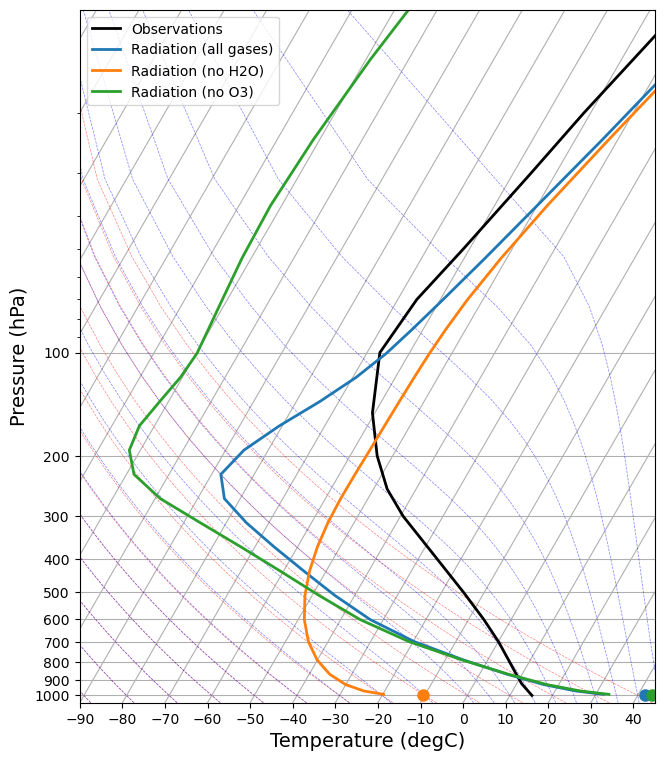

In [64]:
skew = make_skewT()
for model in [radmodel, radmodel_noH2O, radmodel_noO3]:
    add_profile(skew, model)

In [65]:
radmodel_noO3_noH2O = climlab.process_like(radmodel_noO3)
radmodel_noO3_noH2O.name = 'Radiation (no H2O and O3)'
radmodel_noO3_noH2O

In [67]:
radmodel_noO3_noH2O.specific_humidity *= 0
radmodel_noO3_noH2O.specific_humidity

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [68]:
radmodel_noO3_noH2O.step_forward()
while np.abs(radmodel_noO3_noH2O.ASR - radmodel_noO3_noH2O.OLR) > 0.01:
    radmodel_noO3_noH2O.step_forward()

In [69]:
print(radmodel_noO3_noH2O.ASR - radmodel_noO3_noH2O.OLR)

[-0.00994265]


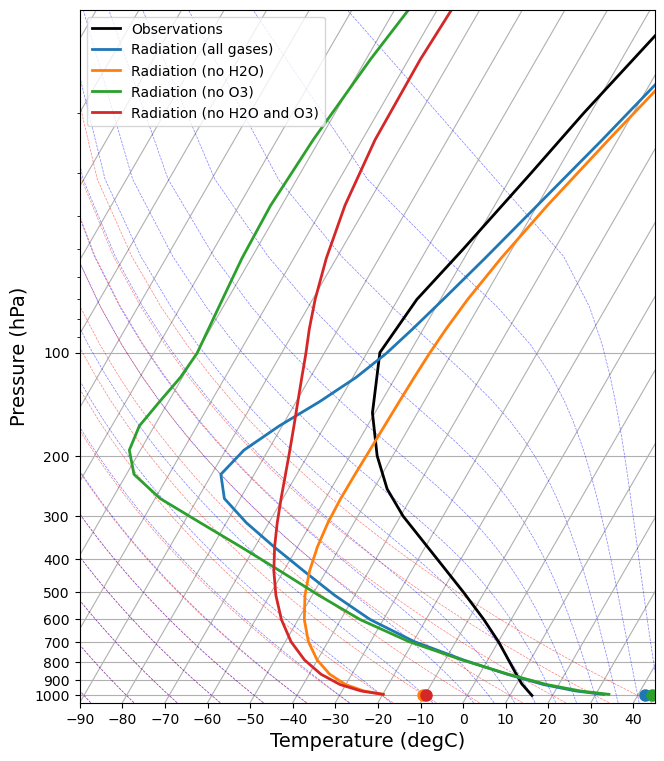

In [70]:
skew = make_skewT()
for model in [radmodel, radmodel_noH2O, radmodel_noO3, radmodel_noO3_noH2O]:
    add_profile(skew, model)

____________

## 6. Summary of radiative equilibrium results
____________

- We used the `RRTMG` radiation model with prescribed profiles of absorbing gases to calculate **pure radiative equilibrium** temperature profiles.
- Radiative Equilibriu means the temperatures that the surface and air column would have **if radiation was the only physical process that could transfer energy between levels**.
- We computed several different radiative equilibrium profiles, with and without key absorbing gases
    - The profile without water vapor is **much colder at surface and lower troposphere**, but about the same in the stratosphere
    - The profile without ozone is **much colder in the stratosphere**, but about the same near the surface.
    - In fact there really isn't a stratosphere at all without ozone! The temperature is nearly isothermal in the upper atmosphere in that profile.

However the really key takeaway message is that **none of these radiative equilibrium profiles look much like the observations in the troposphere**.

This strongly suggests that other physical processes (aside from radiation) are important in determining the observed temperature profile.

Plotting on the skew-T diagram makes it clear that **all the radiative equilibrium profiles are statically unstable near the surface**.

The next step is therefore to look at the effects of convective mixing on the temperatures of the surface and lower troposphere.

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________